## Top Down Modeling Process

The original $Reconstruction$ search feature begins the search space with an empty graph, building up the body from $NewBodyFeatureOperation$, $JoinFeatureOperation$, $CutFeatureOperation$, or $IntersectFeatureOperation$. The search space is originally restricted to $NewBodyFeatureOperation$ since the other operations are not possible on an empty graph. 

<p float="left"> 
  <img src="images/best_search_1.png" style="display:inline;margin:1px;height:300px" /> 
  <img src="images/best_search_2.png" style="display:inline;margin:1px;height:300px" />  
  <img src="images/best_search_3.png" style="display:inline;margin:1px;height:300px" /> 
</p>

<center> Example face extrusion process for original best_search process </center>

### Simulating manufacturing processes in design

#### Overview

There are 2 umbrellas of manufacturing for manufactured parts, additive manufacturing and subtractive manufacturing. Additive manufacturing, such as injection molding and 3D printing, *add* material to create a solid object. Opposite of this is machining, which starts with a block of materials and *subtracts* material to create the final design. Additive manufacturing is like working with clay, whereas subtractive manufacturing is like working with a granite block and chisel. 

Good design practices recommend designing your part in the way that it will be manufactured. If a part is to be manufactured via a subtractive manufacturing process, it is best practice to start your model as a block of material and cut away material. This allows the designer to visualize and optimize the design for the manufcaturing process and allows for easier editing of the design later on. 

The search feature implemented in the $Search$ class and its children start with a blank graph and *add* bodies to form the design. Though its possible for the agent to choose to extrude a bounding box then cut away to the target, it is not guaranteed, and typically not what happens. Further, due to the limitations imposed by the message passing network, namely the fact it returns 2 faces and an operation, as well the rules imposed on the agent (namely the faces must be parallel) there are several more complex shapes that it completely fails at making. Essentially, if there is a face with no parallel faces it canot be created. See examples below of a shape the agent fails to reconstruct. 

<p float="center"> 
  <img src="images/77211_d46ae17d_0013.png" style="height:300px"/> 
</p>

<center> Pyramidal face with no parallel faces fails to be reconstructed </center>

Looking into the ground truth of the above model, it is apparent that the final model was formed from a bounding box, then two extrude cut operations were used to complete the shape. Since the final cuts go all the way through the model, there are no parallel faces for the agent to complete a face extrusion. 

<p float="left"> 
  <img src="images/77211_d46ae17d_0013_0112.png" style="display:inline;margin:1px;height:300px" /> 
  <img src="images/77211_d46ae17d_0013_0116.png" style="display:inline;margin:1px;height:300px" />  
  <img src="images/77211_d46ae17d_0013.png" style="display:inline;margin:1px;height:300px" /> 
</p>

<center> Extrusion steps to recreate the solid object </center>

This particular model fails the search algorithm due to the parallel face limitation of face extrusions. If we were able to start with the bounding box and cut away to reveal the model, however, this could be reconstructed using the existing framework of the search algorithm.

#### Implementation

To implement this, we needed to modify the search algorithm to add a bounding box before each 

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import sys
import os
from IPython.core.display import display, HTML, Image

In [37]:
control_log = "../tools/search/log/"
bounded_log = "../tools/search/log_bounded/"

In [38]:
control_directories = os.listdir(path=control_log)
bounded_directories = os.listdir(path=bounded_log)

In [39]:
bounded_directories

['54077_dd26efde_0000',
 '33967_0741e236_0002',
 '142764_e4f86a3b_0000',
 '77211_d46ae17d_0013',
 '.DS_Store',
 '30246_6e835e6d_0001',
 '41026_295d1dc8_0003',
 '41234_74275eb0_0009',
 '22457_a6c2776f_0008',
 '27839_4a077326_0010',
 '65211_73eab9de_0000',
 'search_results.json',
 '22432_e4a51ee9_0006']

In [40]:
dict_df = {'uuid': [],
             'used_budget': [],
             'max_iou': [],
             'exact': [],
             'bounded': [],
              'feature_operation': []}

In [41]:
bounded = False
for directory in control_directories:
    # Return all files within directory
    try:
        files = os.listdir(os.path.join(control_log, directory))
        for file in files:
            if file.endswith('.json'):
                with open(os.path.join(control_log, directory, file), 'r') as f:
                    f = json.load(f)
                    dict_df['uuid'].append(directory)
                    dict_df['used_budget'].append(f[-1]['used_budget'])
                    dict_df['max_iou'].append(f[-1]['max_iou'])
                    dict_df['exact'].append(True if f[-1]['max_iou'] > 0.99999999 else False)
                    dict_df['bounded'].append(bounded)
    except NotADirectoryError:
        print("{} is not a directory".format(directory))
        
bounded = True
for directory in bounded_directories:
    # Return all files within directory
    try:
        files = os.listdir(os.path.join(bounded_log, directory))
        for file in files:
            if file.endswith('.json'):
                with open(os.path.join(bounded_log, directory, file), 'r') as f:
                    f = json.load(f)
                    dict_df['uuid'].append(directory)
                    dict_df['used_budget'].append(f[-1]['used_budget'])
                    dict_df['max_iou'].append(f[-1]['max_iou'])
                    dict_df['exact'].append(True if f[-1]['max_iou'] > 0.99999999 else False)
                    dict_df['bounded'].append(bounded)
    except NotADirectoryError:
        print("{} is not a directory".format(directory))

.DS_Store is not a directory
search_results.json is not a directory
.DS_Store is not a directory
search_results.json is not a directory


In [42]:
dict_df

{'uuid': ['54077_dd26efde_0000',
  '33967_0741e236_0002',
  '142764_e4f86a3b_0000',
  '77211_d46ae17d_0013',
  '30246_6e835e6d_0001',
  '41026_295d1dc8_0003',
  '41234_74275eb0_0009',
  '22457_a6c2776f_0008',
  '27839_4a077326_0010',
  '65211_73eab9de_0000',
  '22432_e4a51ee9_0006',
  '54077_dd26efde_0000',
  '33967_0741e236_0002',
  '142764_e4f86a3b_0000',
  '77211_d46ae17d_0013',
  '30246_6e835e6d_0001',
  '41026_295d1dc8_0003',
  '41234_74275eb0_0009',
  '22457_a6c2776f_0008',
  '27839_4a077326_0010',
  '65211_73eab9de_0000',
  '22432_e4a51ee9_0006'],
 'used_budget': [20,
  2,
  1,
  20,
  5,
  1,
  8,
  1,
  1,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20],
 'max_iou': [0.8885589429711583,
  1.0,
  1.0,
  0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9996491787019813,
  0.8846035521300826,
  0.056893078284160514,
  0.1866434059880256,
  0,
  0,
  0.5745608575960637,
  0,
  0.7699510644313011,
  0,
  0,
  0.9436155308507842,
  0.7037559354410343],
 'exact

In [43]:
df = pd.DataFrame(dict_df)
df.tail()

,uuid,used_budget,max_iou,exact,bounded
17,41234_74275eb0_0009,20,0.769951,False,True
18,22457_a6c2776f_0008,20,0.000000,False,True
19,27839_4a077326_0010,20,0.000000,False,True
20,65211_73eab9de_0000,20,0.943616,False,True
21,22432_e4a51ee9_0006,20,0.703756,False,True


In [47]:
df.groupby(by='bounded')['max_iou'].describe()

,count,mean,std,min,25%,50%,75%,max
bounded,,,,,,,,
False,11.0,0.888437,0.298132,0.0,0.944104,1.000000,1.000000,1.000000
True,11.0,0.294129,0.373506,0.0,0.000000,0.056893,0.639158,0.943616


In [48]:
df.groupby(by='bounded')['used_budget'].describe()

,count,mean,std,min,25%,50%,75%,max
bounded,,,,,,,,
False,11.0,9.0,8.97775,1.0,1.0,5.0,20.0,20.0
True,11.0,20.0,0.00000,20.0,20.0,20.0,20.0,20.0


/opt/anaconda3/envs/final_project_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/final_project_env/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


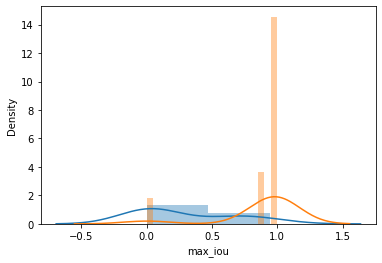

In [45]:
fig, ax = plt.subplots()
sns.distplot(df.loc[df['bounded']==True]['max_iou'])
sns.distplot(df.loc[df['bounded']==False]['max_iou'])
plt.show()